# ResNet-9 — 3D-Print Defect Detection (Safe FP32, Label Mapping in Dataset)

เวอร์ชันนี้ตั้งค่าให้ **นิ่งก่อน**: ไม่ใช้ AMP, ไม่ใช้ fused op ของ `torchvision.ops.misc`, map labels ภายใน `Dataset`, และมี **preflight** ตรวจ CPU/GPU forward ก่อนเข้าเทรน

> หลังรันจบและนิ่งแล้ว ค่อยเปิด AMP/pin_memory/non_blocking และ cuDNN ทีละอย่างภายหลังได้

In [1]:
pip install numpy pandas pillow torch torchvision scikit-learn matplotlib tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ต้องรันเซลล์นี้ก่อน import torch เพื่อให้ traceback ชี้บรรทัดจริงเวลามีเคอร์เนลพัง
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
import os, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

# reproducibility
SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
IN_COLAB = False
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    ROOT = Path("/content/drive/MyDrive/Colab Notebooks/CNN-detect 3dprint-fail")
else:
    # 🖥️ บนเครื่อง (แก้ path ให้ตรงกับโฟลเดอร์โปรเจกต์คุณ)
    ROOT = Path(r"/home/a/rocm_env/bin/Printing_Errors")

IMAGES_ROOT  = ROOT / "images"                 
TRAIN_SUBDIR = "all_images256"                 
CSV_MASTER   = ROOT / "general_data" / "all_images_no_filter.csv"
SPLIT_DIR    = ROOT / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

CLASS_RAW    = [0,1,2,4]
RAW2IDX      = {r:i for i, r in enumerate(CLASS_RAW)}
IDX2RAW      = {i:r for r,i in RAW2IDX.items()}
NUM_CLASSES  = len(CLASS_RAW)

print("ROOT:", ROOT)
print("IMAGES_ROOT exists:", IMAGES_ROOT.exists())
print("CSV_MASTER exists:", CSV_MASTER.exists())

ROOT: /home/a/rocm_env/bin/Printing_Errors
IMAGES_ROOT exists: True
CSV_MASTER exists: True


In [5]:
class FocalLoss(nn.Module):
    """
    Multi-class Focal Loss แบบรับ logits ตรง (ไม่ต้อง softmax เอง)
    y: LongTensor [N] (ค่าคลาส 0..C-1)
    logits: FloatTensor [N, C]
    alpha: None | float | Tensor[C]   -> ถ้าเทนเซอร์จะเป็น weight ต่อคลาส
    gamma: โฟกัส misclassified (ค่า 2.0 ใช้บ่อย)
    """
    def __init__(self, alpha=None, gamma=2.0, reduction="mean", eps=1e-8):
        super().__init__()
        if (alpha is not None) and not torch.is_tensor(alpha):
            alpha = torch.tensor(alpha, dtype=torch.float32)
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits, target):
        # probs = softmax
        log_probs = torch.log_softmax(logits, dim=1)
        probs = log_probs.exp()

        # ดึง p_t ของคลาสจริง
        pt = probs.gather(dim=1, index=target.view(-1,1)).clamp(min=self.eps, max=1.0)
        log_pt = log_probs.gather(dim=1, index=target.view(-1,1))

        # focal factor
        focal = (1.0 - pt) ** self.gamma

        # alpha per class (optional)
        if self.alpha is not None:
            if self.alpha.device != logits.device:
                self.alpha = self.alpha.to(logits.device)
            at = self.alpha.gather(0, target.view(-1))
            loss = -at.view(-1,1) * focal * log_pt
        else:
            loss = -focal * log_pt

        loss = loss.view(-1)
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss


In [6]:
# --- โหลด CSV (auto delimiter) ---
df_master = pd.read_csv(CSV_MASTER, sep=None, engine='python', encoding='utf-8')
df_master.columns = [c.strip() for c in df_master.columns]
assert {"image","class"}.issubset(df_master.columns), "CSV must include 'image' and 'class'"

# เฉพาะคลาสที่ใช้
df_master = df_master[df_master["class"].isin(CLASS_RAW)].copy()

# normalize path
df_master["image"] = df_master["image"].astype(str).str.strip().str.replace("\\", "/", regex=False)

def ensure_subdir_path(s: str) -> str:
    return s if "/" in s else f"{TRAIN_SUBDIR}/{s}"
df_master["image"] = df_master["image"].apply(ensure_subdir_path)

# เก็บเฉพาะที่อยู่ในโดเมน train_subdir
df_master = df_master[df_master["image"].str.startswith(f"{TRAIN_SUBDIR}/", na=False)].reset_index(drop=True)

# เก็บเฉพาะไฟล์ที่มีจริง
def exists_image(rel: str) -> bool:
    return (IMAGES_ROOT / rel).exists()
df_master = df_master[df_master["image"].apply(exists_image)].reset_index(drop=True)
print("Total images (train domain & exists):", len(df_master))

# --- Split Train and Test ---
def split_train_test(df, group_col="recording", test_size=0.30, seed=42):
    if group_col in df.columns and df[group_col].notna().any():
        groups = df[group_col].fillna("nogroup")
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        i_tr, i_te = next(gss.split(df, groups=groups))
        return df.iloc[i_tr].copy(), df.iloc[i_te].copy()
    else:
        y = df["class"]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        i_tr, i_te = next(sss.split(df, y))
        return df.iloc[i_tr].copy(), df.iloc[i_te].copy()

# Split into train and test sets
df_tr, df_te = split_train_test(df_master, group_col="recording", test_size=0.30, seed=42)

# Save the split data
df_tr.to_csv(SPLIT_DIR/"train.csv", index=False)
df_te.to_csv(SPLIT_DIR/"test.csv", index=False)

# --- Display class distribution in Train and Test sets ---
print("Split sizes -> Train:", len(df_tr), " Test:", len(df_te))

# Show class distribution in the training set
print("\nClass distribution in training set:")
print(df_tr["class"].value_counts())

# Show class distribution in the testing set
print("\nClass distribution in testing set:")
print(df_te["class"].value_counts())


Total images (train domain & exists): 16287
Split sizes -> Train: 11456  Test: 4831

Class distribution in training set:
class
0    5133
1    3184
2    2977
4     162
Name: count, dtype: int64

Class distribution in testing set:
class
1    2328
0    1893
2     532
4      78
Name: count, dtype: int64


In [7]:
# --- สร้าง alpha (weights ต่อคลาส) จาก train set แบบ inverse frequency ---
# นับจาก 'class' ดิบ แล้ว map เป็นดัชนี 0..NUM_CLASSES-1 ให้ครบทุกคลาส
vc = df_tr["class"].map(RAW2IDX).value_counts().reindex(range(NUM_CLASSES), fill_value=0)

# ป้องกันหาร 0
vc = vc.clip(lower=1)

# inverse frequency แล้ว normalize ให้ผลรวม = NUM_CLASSES (สเกลสวยๆ)
inv = 1.0 / vc.astype(float)
alpha_np = (NUM_CLASSES * inv / inv.sum()).values.astype("float32")

print("Train class counts (by index):", vc.to_dict())
print("Alpha (per index 0..C-1):", alpha_np)

ALPHA_TENSOR = torch.tensor(alpha_np, dtype=torch.float32)  # เก็บไว้ใช้ตอนสร้าง criterion


Train class counts (by index): {0: 5133, 1: 3184, 2: 2977, 3: 162}
Alpha (per index 0..C-1): [0.1110447  0.17901774 0.1914654  3.5184722 ]


In [8]:
# --- Dataset พร้อม map label ภายใน ---
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        p = self.root_dir / self.df.loc[idx, "image"]
        y_raw = int(self.df.loc[idx, "class"])  # 0,1,2,4
        y = RAW2IDX[y_raw]                       # 0..3
        x = Image.open(p).convert("RGB")
        if self.transform: 
            x = self.transform(x)
        return x, y

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

ds_train = CustomImageDataset(df_tr, IMAGES_ROOT, transform)
ds_test  = CustomImageDataset(df_te, IMAGES_ROOT, transform)

BATCH = 64
# ⚡ CPU friendly DataLoader (no pin_memory, no persistent_workers)
train_ld = DataLoader(ds_train, batch_size=BATCH, shuffle=True,
                      num_workers=12, pin_memory=True, persistent_workers=True)
test_ld  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False,
                      num_workers=12, pin_memory=True, persistent_workers=True)

# Sanity batch
xb, yb = next(iter(train_ld))
print("Batch:", xb.shape, xb.dtype, "targets:", int(yb.min()), "->", int(yb.max()))


Batch: torch.Size([64, 3, 256, 256]) torch.float32 targets: 0 -> 3


In [9]:
# --- ResNet-9 (Conv+BN+ReLU ธรรมดา; ไม่มี fused ops) ---
def conv_bn_relu(in_c, out_c, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=False),
    )

class BasicBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv1 = conv_bn_relu(c, c)
        self.conv2 = nn.Sequential(
            nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c),
        )
        self.relu = nn.ReLU(inplace=False)
    def forward(self, x):
        id = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + id
        return self.relu(x)

class ResNet9(nn.Module):
    def __init__(self, in_ch=3, num_classes=NUM_CLASSES):
        super().__init__()
        self.layer1 = conv_bn_relu(in_ch, 64, 3, 1, 1)
        self.layer2 = conv_bn_relu(64, 128, 3, 2, 1)
        self.res1   = BasicBlock(128)
        self.layer3 = conv_bn_relu(128, 256, 3, 2, 1)
        self.layer4 = conv_bn_relu(256, 512, 3, 2, 1)
        self.res2   = BasicBlock(512)
        self.pool   = nn.AdaptiveAvgPool2d(1)
        self.fc     = nn.Linear(512, NUM_CLASSES)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x); x = self.res1(x)
        x = self.layer3(x)
        x = self.layer4(x); x = self.res2(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

model = ResNet9().float().to(device)
print(model.__class__.__name__, "on", device)

ResNet9 on cuda


In [10]:
# --- Preflight: CPU แล้ว GPU FP32 ---
m_cpu = ResNet9().float().cpu().eval()
with torch.no_grad():
    _ = m_cpu(xb.float())
print("[CPU] forward OK")

cudnn.enabled = False; cudnn.benchmark = False; cudnn.deterministic = True
m_gpu = ResNet9().float().to(device).eval()
with torch.no_grad():
    _ = m_gpu(xb.float().to(device))
print("[GPU] forward OK (FP32, no AMP, no cuDNN)")

[CPU] forward OK
[GPU] forward OK (FP32, no AMP, no cuDNN)


In [11]:
print("len(ds_train) =", len(ds_train), " | len(train_ld) (batches) =", len(train_ld))
# ดูตัวอย่างไฟล์ 3 รายการแรก
for i in range(min(3, len(ds_train))):
    p = IMAGES_ROOT / ds_train.df.loc[i, "image"]
    print(f"[{i}] exists={p.exists()}  ->", p)

# ลองดึง batch แรก (จะรู้เลยว่าติดตรงนี้ไหม)
xb, yb = next(iter(train_ld))
print("First batch OK:", xb.shape, yb.shape, yb.min().item(), yb.max().item())


len(ds_train) = 11456  | len(train_ld) (batches) = 179
[0] exists=True  -> /home/a/rocm_env/bin/Printing_Errors/images/all_images256/ELP_12MP_01.12.2022_166990882982.png
[1] exists=True  -> /home/a/rocm_env/bin/Printing_Errors/images/all_images256/ELP_12MP_01.12.2022_166990882986.png
[2] exists=True  -> /home/a/rocm_env/bin/Printing_Errors/images/all_images256/ELP_12MP_01.12.2022_166990887746.png
First batch OK: torch.Size([64, 3, 256, 256]) torch.Size([64]) 0 2


In [12]:
# ========= FAST TRAIN LOOP =========
from tqdm.auto import tqdm
import torch.backends.cudnn as cudnn

EPOCHS = 30
BATCH  = 64   # เพิ่ม batch ให้ใหญ่ขึ้นถ้า VRAM พอ

USE_FOCAL = True
FOCAL_GAMMA = 2.0  # ค่ามาตรฐานที่นิยม: 1.5–2.5

if USE_FOCAL:
    criterion = FocalLoss(alpha=ALPHA_TENSOR, gamma=FOCAL_GAMMA, reduction="mean")
else:
    # เผื่ออยากเทียบ
    # class_weights = torch.tensor((1.0 / vc.values) * (len(vc) / (1.0 / vc.values).sum()), dtype=torch.float32)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# เปิด cuDNN ให้ optimize
cudnn.enabled = True
cudnn.benchmark = True

# เปิด Automatic Mixed Precision (AMP)
USE_AMP = True
scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)
model.eval()
with torch.no_grad():
    x_chk, y_chk = next(iter(train_ld))
    x_chk, y_chk = x_chk.to(device), y_chk.to(device)
    logits_chk = model(x_chk)
    loss_chk = criterion(logits_chk, y_chk)
    print(f"[Sanity] focal loss = {loss_chk.item():.4f}")
model.train()


/home/a/rocm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Sanity] focal loss = 0.2073


ResNet9(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res1): BasicBlock(
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_si

In [13]:
for ep in range(1, EPOCHS+1):
    model.train()
    total = correct = 0
    run_loss = 0.0

    pbar = tqdm(train_ld, desc=f"Epoch {ep}/{EPOCHS}", unit="batch", leave=True)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = torch.as_tensor(y, dtype=torch.long, device=device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=USE_AMP):
            logits = model(x)
            loss   = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        run_loss += loss.item() * bs
        total    += bs
        correct  += (logits.argmax(1) == y).sum().item()

        pbar.set_postfix({"loss": f"{run_loss/total:.4f}", "acc": f"{correct/total:.3f}"})

    print(f"[Epoch {ep:02d}] loss {run_loss/total:.4f}  acc {correct/total:.3f}")

# ========= Evaluate (GPU-friendly, per-class recall & balanced acc) =========
from sklearn.metrics import recall_score, balanced_accuracy_score

model.eval()
ep_true, ep_pred = [], []

with torch.inference_mode():
    for x, y in test_ld:
        # ส่งทั้งภาพและเลเบลขึ้นอุปกรณ์ (CUDA/CPU) ให้ตรงกับโมเดล
        x = x.to(device, non_blocking=(device.type == "cuda"))
        y = torch.as_tensor(y, dtype=torch.long, device=device)

        logits = model(x)
        preds  = logits.argmax(1)

        # เก็บผลกลับ CPU/NumPy เพื่อใช้กับ sklearn
        ep_true.extend(y.cpu().tolist())
        ep_pred.extend(preds.cpu().tolist())

# คำนวณเมตริก
ep_true = np.array(ep_true, dtype=np.int64)
ep_pred = np.array(ep_pred, dtype=np.int64)

per_class_recall = recall_score(
    ep_true, ep_pred,
    labels=list(range(NUM_CLASSES)),
    average=None, zero_division=0
)
bal_acc = balanced_accuracy_score(ep_true, ep_pred)

print("balanced_acc =", f"{bal_acc:.4f}",
      " | per-class recall =", {i: float(r) for i, r in enumerate(per_class_recall)})

# (ออปชัน) กลับเข้าโหมดเทรนถ้าบล็อกนี้อยู่ในลูป epochs
model.train()


Epoch 1/30: 100%|██████████| 179/179 [02:31<00:00,  1.18batch/s, loss=0.0544, acc=0.655] 


[Epoch 01] loss 0.0544  acc 0.655


Epoch 2/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0344, acc=0.731]


[Epoch 02] loss 0.0344  acc 0.731


Epoch 3/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0228, acc=0.799]


[Epoch 03] loss 0.0228  acc 0.799


Epoch 4/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0207, acc=0.827]


[Epoch 04] loss 0.0207  acc 0.827


Epoch 5/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0157, acc=0.863]


[Epoch 05] loss 0.0157  acc 0.863


Epoch 6/30: 100%|██████████| 179/179 [00:47<00:00,  3.78batch/s, loss=0.0147, acc=0.874]


[Epoch 06] loss 0.0147  acc 0.874


Epoch 7/30: 100%|██████████| 179/179 [00:47<00:00,  3.78batch/s, loss=0.0101, acc=0.912]


[Epoch 07] loss 0.0101  acc 0.912


Epoch 8/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0096, acc=0.920]


[Epoch 08] loss 0.0096  acc 0.920


Epoch 9/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0087, acc=0.926]


[Epoch 09] loss 0.0087  acc 0.926


Epoch 10/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0089, acc=0.936]


[Epoch 10] loss 0.0089  acc 0.936


Epoch 11/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0134, acc=0.905]


[Epoch 11] loss 0.0134  acc 0.905


Epoch 12/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0082, acc=0.934]


[Epoch 12] loss 0.0082  acc 0.934


Epoch 13/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0056, acc=0.958]


[Epoch 13] loss 0.0056  acc 0.958


Epoch 14/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0038, acc=0.969]


[Epoch 14] loss 0.0038  acc 0.969


Epoch 15/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0038, acc=0.968]


[Epoch 15] loss 0.0038  acc 0.968


Epoch 16/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0033, acc=0.971]


[Epoch 16] loss 0.0033  acc 0.971


Epoch 17/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0033, acc=0.974]


[Epoch 17] loss 0.0033  acc 0.974


Epoch 18/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0034, acc=0.970]


[Epoch 18] loss 0.0034  acc 0.970


Epoch 19/30: 100%|██████████| 179/179 [00:47<00:00,  3.78batch/s, loss=0.0045, acc=0.967]


[Epoch 19] loss 0.0045  acc 0.967


Epoch 20/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0031, acc=0.976]


[Epoch 20] loss 0.0031  acc 0.976


Epoch 21/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0100, acc=0.945]


[Epoch 21] loss 0.0100  acc 0.945


Epoch 22/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0031, acc=0.975]


[Epoch 22] loss 0.0031  acc 0.975


Epoch 23/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0032, acc=0.973]


[Epoch 23] loss 0.0032  acc 0.973


Epoch 24/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0027, acc=0.978]


[Epoch 24] loss 0.0027  acc 0.978


Epoch 25/30: 100%|██████████| 179/179 [00:47<00:00,  3.76batch/s, loss=0.0128, acc=0.932]


[Epoch 25] loss 0.0128  acc 0.932


Epoch 26/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0053, acc=0.961]


[Epoch 26] loss 0.0053  acc 0.961


Epoch 27/30: 100%|██████████| 179/179 [00:47<00:00,  3.78batch/s, loss=0.0026, acc=0.981]


[Epoch 27] loss 0.0026  acc 0.981


Epoch 28/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0017, acc=0.987]


[Epoch 28] loss 0.0017  acc 0.987


Epoch 29/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0013, acc=0.990]


[Epoch 29] loss 0.0013  acc 0.990


Epoch 30/30: 100%|██████████| 179/179 [00:47<00:00,  3.77batch/s, loss=0.0014, acc=0.990]

[Epoch 30] loss 0.0014  acc 0.990


balanced_acc = 0.5971  | per-class recall = {0: 0.7099841521394612, 1: 0.9153780068728522, 2: 0.5451127819548872, 3: 0.21794871794871795}


ResNet9(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res1): BasicBlock(
    (conv1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_si


=== TEST SCORES ===
Accuracy               : 0.7829
Balanced Accuracy      : 0.5971
Top-2 Accuracy         : 0.9369
Log Loss               : 1.0548
MCC                    : 0.6313
Cohen's Kappa          : 0.6256
Precision (micro/macro/weighted): 0.7829 / 0.7783 / 0.7832
Recall    (micro/macro/weighted): 0.7829 / 0.5971 / 0.7829
F1        (micro/macro/weighted): 0.7829 / 0.6439 / 0.7748

--- Classification report (per class) ---
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1893
           1       0.78      0.92      0.84      2328
           2       0.81      0.55      0.65       532
           4       0.74      0.22      0.34        78

    accuracy                           0.78      4831
   macro avg       0.78      0.60      0.64      4831
weighted avg       0.78      0.78      0.77      4831



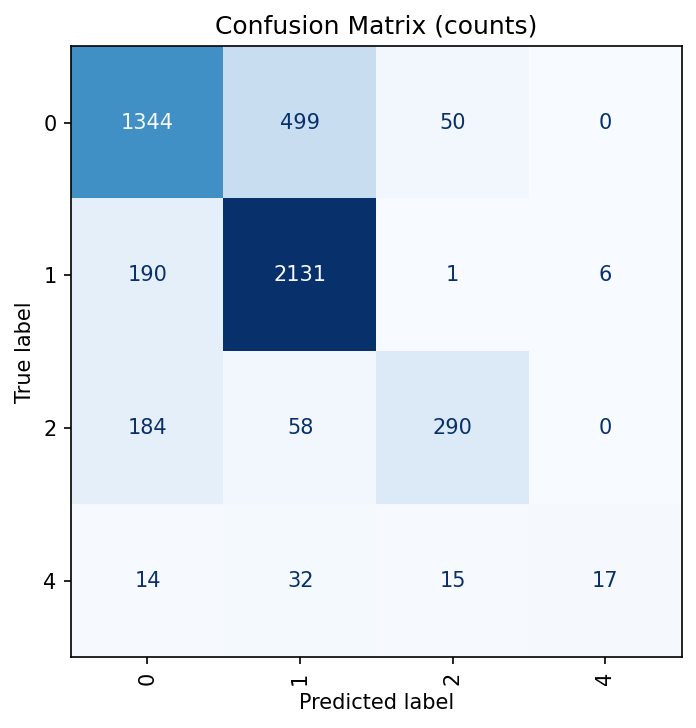

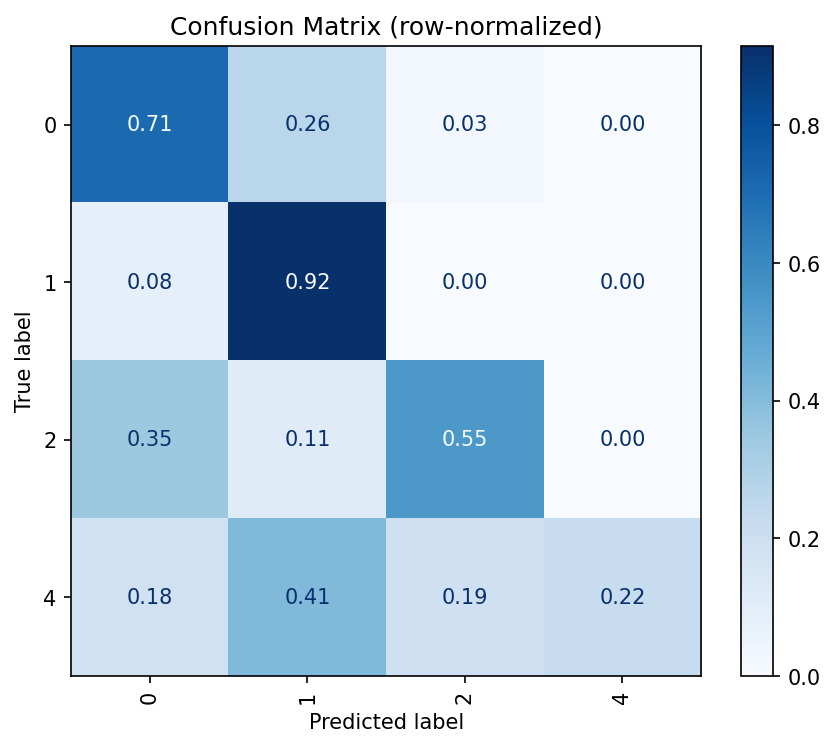

In [14]:
# ========= Evaluate + Metrics + Confusion Matrix =========
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    classification_report, matthews_corrcoef, cohen_kappa_score,
    confusion_matrix, ConfusionMatrixDisplay, log_loss, top_k_accuracy_score
)
import torch.nn.functional as F

model.eval()
y_true, y_pred = [], []
all_probs = []

with torch.inference_mode():
    for x, y in test_ld:
        x = x.to(device)
        logits = model(x)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)

        y_true.extend(torch.as_tensor(y).tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs  = np.concatenate(all_probs, axis=0)  # shape: [N, NUM_CLASSES]

# --- Core scores ---
acc      = accuracy_score(y_true, y_pred)
bal_acc  = balanced_accuracy_score(y_true, y_pred)
mcc      = matthews_corrcoef(y_true, y_pred)
kappa    = cohen_kappa_score(y_true, y_pred)
top2_acc = top_k_accuracy_score(y_true, probs, k=2, labels=list(range(NUM_CLASSES)))
lloss    = log_loss(y_true, probs, labels=list(range(NUM_CLASSES)))

# --- PRF (average หลายแบบ) ---
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print(f"\n=== TEST SCORES ===")
print(f"Accuracy               : {acc:.4f}")
print(f"Balanced Accuracy      : {bal_acc:.4f}")
print(f"Top-2 Accuracy         : {top2_acc:.4f}")
print(f"Log Loss               : {lloss:.4f}")
print(f"MCC                    : {mcc:.4f}")
print(f"Cohen's Kappa          : {kappa:.4f}")
print(f"Precision (micro/macro/weighted): {prec_micro:.4f} / {prec_macro:.4f} / {prec_w:.4f}")
print(f"Recall    (micro/macro/weighted): {rec_micro:.4f} / {rec_macro:.4f} / {rec_w:.4f}")
print(f"F1        (micro/macro/weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_w:.4f}")

# --- รายงานรายคลาส ---
labels_vis = [str(IDX2RAW[i]) for i in range(NUM_CLASSES)]
print("\n--- Classification report (per class) ---")
print(classification_report(y_true, y_pred, labels=list(range(NUM_CLASSES)),
                            target_names=labels_vis, zero_division=0))

# --- Confusion matrices ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ConfusionMatrixDisplay(cm, display_labels=labels_vis).plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (counts)"); plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=90); plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ConfusionMatrixDisplay(cm_norm, display_labels=labels_vis).plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Confusion Matrix (row-normalized)"); plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=90); plt.show()

# (ออปชัน) เซฟรายงานรายคลาสเป็น CSV
per_class = precision_recall_fscore_support(y_true, y_pred,
                                            labels=list(range(NUM_CLASSES)),
                                            zero_division=0)
df_report = pd.DataFrame({
    "class_raw": labels_vis,
    "precision": per_class[0],
    "recall":    per_class[1],
    "f1":        per_class[2],
    "support":   per_class[3]
})
# df_report.to_csv("per_class_report.csv", index=False)
